<a href="https://www.kaggle.com/code/killianmcguinness/time-series-forecasting-calls-to-sf-999?scriptVersionId=164997143" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 # Evaluating the Best Time Series Forecasting Model to Predict Call Center Volumes

## Objective: ##
Evaluating multiple time series forecasting models using a dataset from San Francisco's 999 Department, a typical format for a contact center, to determine the most accurate model for predicting future call patterns.
 
 ## About The Data: ##
 The Data I've used has been sourced from Google Cloud's [Public Repo](https://console.cloud.google.com/marketplace/product/san-francisco-public-data/sffd-service-calls?project=nth-fiber-389914), the Data set is super typical of what you would find in any Contact center. This data includes fire unit responses to calls from April 2000 to present and is updated daily. Data contains the call number, incident number, address, unit identifier, call type, and disposition. Relevant time intervals are also included. 
 
 **Period:** January 1st 2021 to November 28th 2023

# Time Series Forecast Model Evaluation Action Plan
| Step | Task                                   | Objective                                               | Details                                            |
|------|----------------------------------------|---------------------------------------------------------|----------------------------------------------------|
| 1    | Explore the Data Set                   | Understand data structure, features, and patterns.        | - Load Dataframe. <br> - Examine data types, missing values, and basic statistics. <br> - Visualize data distributions and relationships. |
| 2    | Create Test / Train Split                   | prepare data for model training & evaluation.        | - Split the dataset into training and testing sets. <br> - Define the features (X) and target variable (y). |
| 3    | Train the Model using Simple sklearn Regression                   | Establish baseline with a basic regression model.        | - Import and train a simple linear regression model using sklearn. <br> |
| 4    | Train a Model using XGBRegressor                   | Explore performance with an advanced regression model.        | -  Import and train an XGBRegressor model. |
| 5    | Train a Model using PyCaret                   | Leverage PyCaret for efficient and automated training.        | -  Install and import PyCaret. <br> - Setup and train a regression model using PyCaret <br> - Plot Top 5 Modles & select Best. |
| 6    | Train a Model using Prophet                   | Investigate time-series forecasting using Prophet.        | -  Import and train linear regression model using Prophet. |
| 7    | Score & Visualise Each Model                  | Evaluate Each Model using R-Squared (R2) and Mean Square Error (MSE) Metrirics .        | -  Visualise R2 & MSE Scores for 4 Models. <br> - Plot Each Models predicted 2023 vs Actual 2023 |

# Step 1: Explore the Data Set
### Understand data structure, features & patterns. <br>

**1. Import Key Libraries:**
- Import necessary libraries, there are quite a few!.

**2. Query The Datas from Goole Cloud:**
- This is a publicly available Dataset hosted on Google Cloud's big query, uncomment to update the Query. To save computing dower I've saved the DF and loaded to input.

**3. Visualise Incoming Call Patterns:**
- Group data by call date to create separate dataframes for daily, weekly, monthly, and day of week views..
- Plot each dataframe to visualize call arrival patterns. 📅📞

**4. Clean up outliers:**
- We can clearly see some distinct peaks, to ensure this does not Impact our results we'll smooth these peaks.

**Clean up Steps:**
1. Computed quartile summary.
2. Replaced values > 200 with Q3 mean.
3. Replaced values < 50 with Q1 mean.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

color_pal = sns.color_palette("tab20c")
plt.style.use('fivethirtyeight')

color_brand = ['#ABE3C4', '#E7F7EE', '#5F8778', '#85B59E', '#E3ABCA', '#FFCCCC', '#F18C72', '#6BAED6', '#9ECAE1', '#D9D9D9']

titles_dict = {'fontsize': 28,
 'fontweight': 25,
 'color':   color_brand[2]}

sub_title_dict = {'fontsize': 20,
 'fontweight': 18,
 'color':   color_brand[2]}

fig_text_dict = {
    'color':   color_brand[2], 
}

textprops={'color': color_brand[2], 'fontsize':8}

In [2]:
# UNCOMMENT TO RUN query on google cloud
# !pip install google-cloud-bigquery

# from google.cloud import bigquery

# client = bigquery.Client()

# query = """
# SELECT call_type, call_date, received_timestamp, available_timestamp, call_final_disposition 
# FROM `bigquery-public-data.san_francisco_sffd_service_calls.sffd_service_calls` 
# WHERE EXTRACT(YEAR FROM call_date) IN (2020, 2021, 2022, 2023)
# """
# df = client.query(query).to_dataframe()
# df.to_csv('/kaggle/output/999-calls-sf-20-23.csv')

In [3]:
df = pd.read_csv('/kaggle/input/999-calls-sf-20-23/999_calls_sf_20_23.csv')

In [4]:
#Converts date and time columns in df to a datetime format, handling errors by setting problematic values to NaT.
date_time_cols = ['call_date', 'received_timestamp', 'available_timestamp']
for col in date_time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [5]:
# Create seperate Dataframes for daily, weekly, monthly & day of week to plot in next kernel
data = df[['call_date', 'call_type']]
data = data.rename(columns = {'call_type' : 'totals'})

data = data.groupby('call_date', as_index=False).count()

daily_recieved = data.set_index('call_date')

weekly_recieved = data.groupby(pd.Grouper(key='call_date', freq='W')).sum()

monthly_recieved = data.groupby(pd.Grouper(key='call_date', freq='M')).sum()

day_of_week = daily_recieved
day_of_week['week_day'] = day_of_week.index.dayofweek
day_of_week = day_of_week.groupby('week_day').sum()

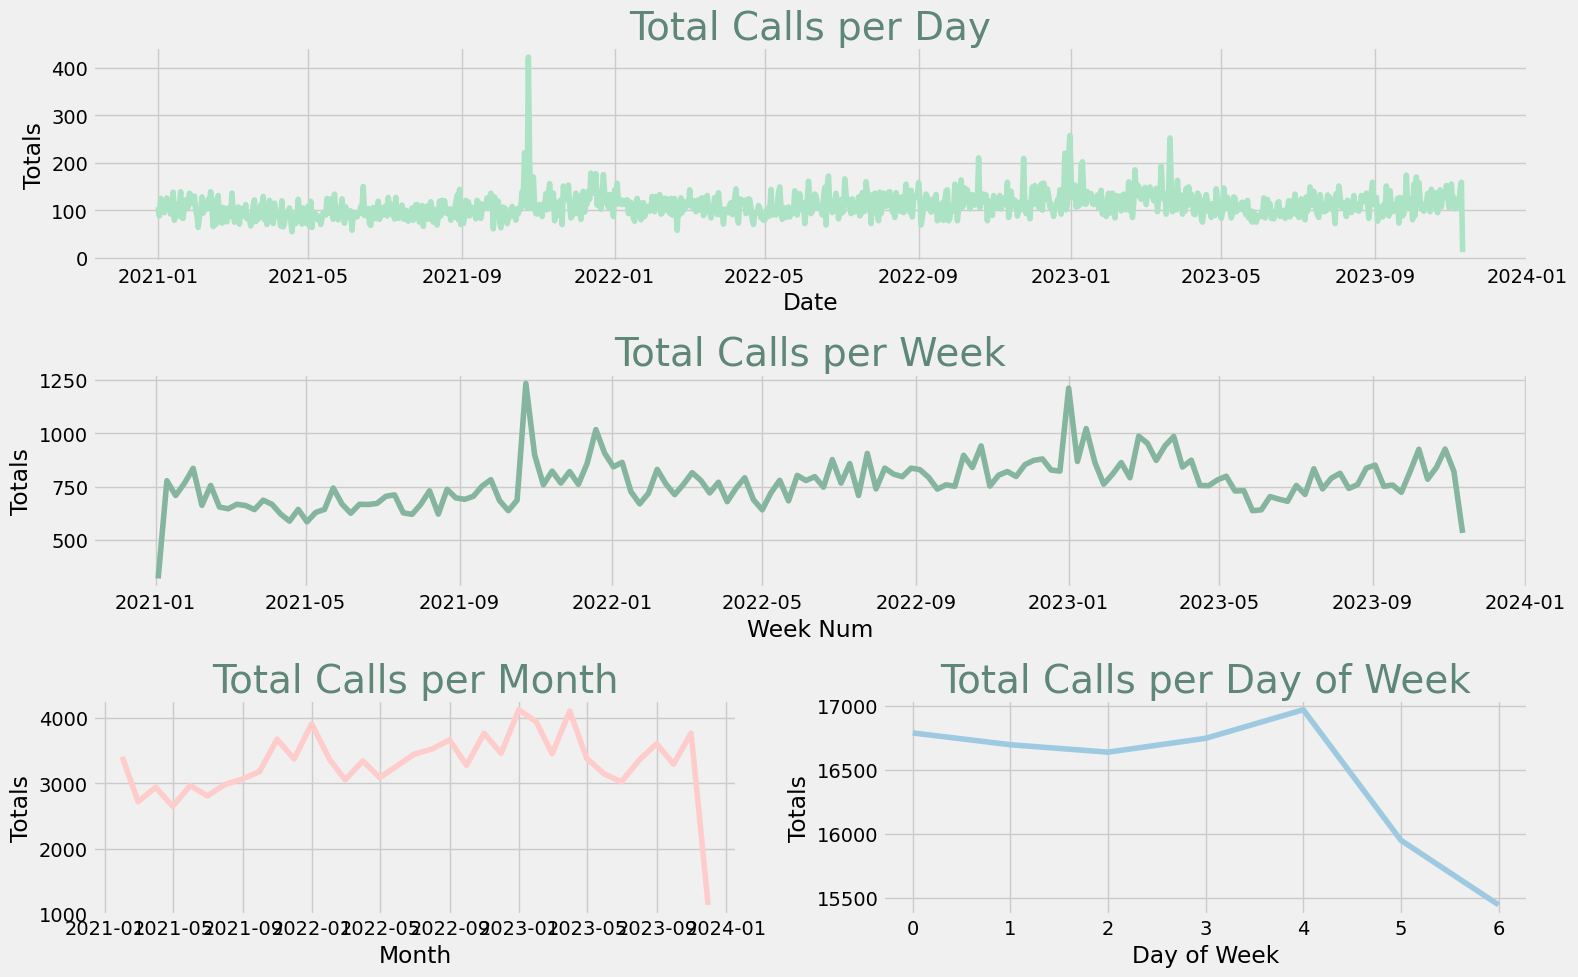

In [6]:
# plot arrival patterns
fig = plt.figure(tight_layout=True, figsize=(16, 10))
gs = gridspec.GridSpec(3, 2)

ax = fig.add_subplot(gs[0, :])
ax.plot(daily_recieved['totals'], color=color_brand[0])
ax.set_ylabel('Totals')
ax.set_xlabel('Date')
ax.set_title('Total Calls per Day', fontdict=titles_dict)

ax = fig.add_subplot(gs[1, :])
ax.plot(weekly_recieved, color=color_brand[3])
ax.set_ylabel('Totals')
ax.set_xlabel('Week Num')
ax.set_title('Total Calls per Week', fontdict=titles_dict)

ax = fig.add_subplot(gs[2, 0])
ax.plot(monthly_recieved, color=color_brand[5])
ax.set_ylabel('Totals')
ax.set_xlabel('Month')
ax.set_title('Total Calls per Month', fontdict=titles_dict)

ax = fig.add_subplot(gs[2, 1])
ax.plot(day_of_week, color=color_brand[8])
ax.set_ylabel('Totals')
ax.set_xlabel('Day of Week')
ax.set_title('Total Calls per Day of Week', fontdict=titles_dict)


plt.show()

In [7]:
#Daily & Weekly Scatters highlight some outliers. I'll use Mean for Quartiles 1 & 3 to replace any significant outliers (In this case, < 200 or > 50)
quartile_summary = data['totals'].describe()
q1 = quartile_summary['25%']
q3 = quartile_summary['75%']

data.loc[data['totals'] > 200, 'totals'] = q3.mean()
data.loc[data['totals'] < 50, 'totals'] = q1.mean()

# Step 2: Create a Test / Train split
## Prepare data for model training and evaluation. <br>

**1. Function `create_features(df)`:**
- Clones the DataFrame & Adds cool time series features: `dayofweek`, `month`, `dayofyear`, `dayofmonth`, `weekofyear`.

**2. Train/Test Split Plot:** 📈
- Split the data into training and test sets based on dates.
- Visualizes the split with a slick plot. Training before '01-01-2023' and testing after.

**3. Feature Magic:** ✨
- Expands the feature set for both training and test sets.
- Features include `dayofweek`, `month`, `dayofyear`, `dayofmonth`, `weekofyear`.

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [9]:
data_with_features = create_features(data.set_index('call_date'))

In [10]:
train = data_with_features.loc[data_with_features.index < '01-01-2023']
test = data_with_features.loc[data_with_features.index >= '01-01-2023']

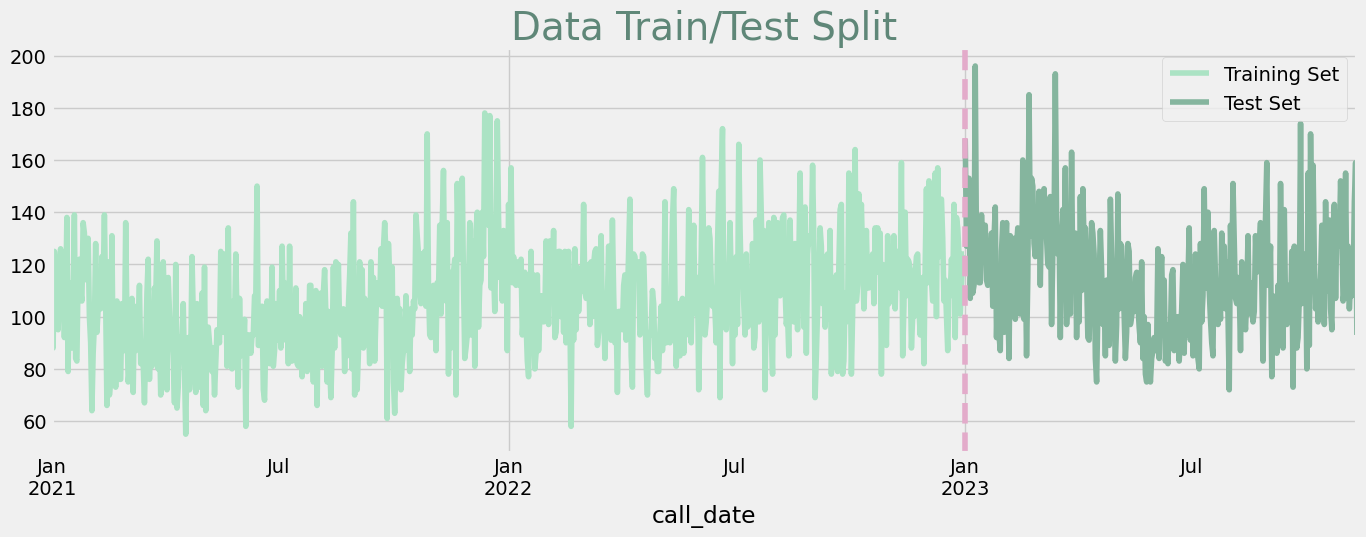

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
train['totals'].plot(ax=ax, label='Training Set', color=color_brand[0])
test['totals'].plot(ax=ax, label='Test Set', color=color_brand[3])
ax.axvline('01-01-2023', color=color_brand[4], ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Data Train/Test Split', fontdict=titles_dict)
plt.show()

In [12]:
# train = create_features(train)
# test = create_features(test)

FEATURES = ['dayofweek', 'month', 'dayofyear', 'dayofmonth', 'weekofyear']
TARGET = 'totals'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Step 3: Train the Model using Simple sklearn Regression
## Establish baseline with a basic regression model.<br>

1. **Time Conversion Functions:** 🔄
   - Convert the timestamp index to seconds since the epoch for both training and testing data.

2. **Data Preparation and Modeling:** 📈
   - Prepare train-test data for linear regression modeling and fits a linear regression model to the training data.

3. **Prediction and Evaluation:** 🎓
   - The model predicts on the test data, calculates mean squared error and R-squared scores, and prints the results.

4. **Dataframe Creation:** 🔮
   - Converts the test data timestamps to datetime objects and creates a DataFrame with actual and predicted values..

In [13]:
def convert_timestamp_secs(df):
    """
    Converts the timestamp index of a DataFrame to seconds since the epoch.
    """
    df.index = (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    return df


def convert_secs_to_timestamp(df):
    """
    Converts the timestamp index of a DataFrame from seconds since the epoch to a datetime object.
    """
    df.index = pd.to_datetime(df.index, unit='s')
    return df

In [14]:
train_test_data = [X_train, y_train, X_test, y_test]
for i in train_test_data:
    convert_timestamp_secs(i)

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
y_prediction = model.predict(X_test)

In [17]:
mse_skl = mean_squared_error(y_test, y_prediction)
r2_skl = r2_score(y_test, y_prediction)

print(f'Mean Squared Error: {mse_skl}')
print(f'R2 Score: {r2_skl}')

Mean Squared Error: 568.0612818157224
R2 Score: -0.20800391811985186


In [18]:
RESULTS_2023 = convert_secs_to_timestamp(y_test)
RESULTS_2023 = RESULTS_2023.to_frame(name='actuals_2023')
RESULTS_2023['predictions_skl'] = y_prediction

In [19]:
SCORES = pd.DataFrame({'score_type': ['mse', 'r2'], 'sklearn': [mse_skl, r2_skl]})

In [20]:
train_test_data = [X_train, y_train, X_test, y_test]
for i in train_test_data:
    convert_secs_to_timestamp(i)

# Step 4: Train a Model using XGBRegressor
## Explore performance with an advanced regression model. <br>

1. **Model Training:** 🎓
   - Using XGBoost Regressor, we trained a model with 1000 estimators, early stopping at 50 rounds, and a linear regression objective.

2. **Feature Importance Plot:** 📊
   - Checked what our model thinks is important with a cool bar plot.

3. **Prediction vs. Truth Plot:** 📈
   - Plotted real vs. predicted values to see how our model performs.

4. **Focused Week Plot:** 📆
   - Zoomed into a specific week to get a closer look at the action.

5. **RMSE Score:** 🔍
   - Calculated the Root Mean Squared Error (RMSE) on the test set. Lower is better!

6. **Top 10 Daily Errors:** 📉
   - Found the dates where our model needs a bit of improvement. Watch out for those!

In [21]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:107.46535	validation_1-rmse:115.37138
[100]	validation_0-rmse:43.58874	validation_1-rmse:52.35262
[200]	validation_0-rmse:24.01441	validation_1-rmse:31.91868


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:10:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:19.58603	validation_1-rmse:25.89805
[400]	validation_0-rmse:18.68464	validation_1-rmse:24.21638
[500]	validation_0-rmse:18.35025	validation_1-rmse:23.73503
[600]	validation_0-rmse:18.12455	validation_1-rmse:23.64119
[661]	validation_0-rmse:17.99707	validation_1-rmse:23.64475


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

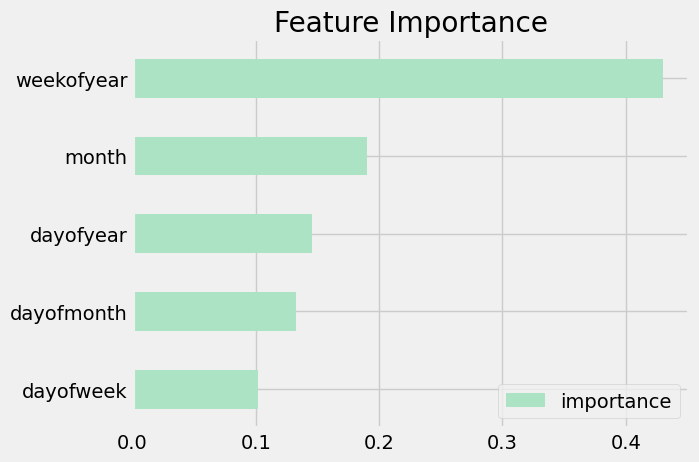

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', color=color_brand[0])
plt.show()

In [23]:
y_pred_XGB = reg.predict(X_test)
RESULTS_2023['predictions_XGB'] = y_pred_XGB

In [24]:
mse_XGB = mean_squared_error(y_test, y_pred_XGB)
r2_XGB = r2_score(y_test, y_pred_XGB)
SCORES['XGB'] = [mse_XGB, r2_XGB]

# Step 5: Train a Model using PyCaret

## PyCaret Time Series Forecasting module is designed to simplify the process of building, comparing, and deploying forecasting models, we're going to use it's compare model's function to find the Top 5 performing Models & then select one. <br>

1. **Install Pycaret:**
   - Run `pip install pycaret`. Easy peasy!

2. **Feature Engineering:**
   - Use `create_features` to jazz up our data (`daily_recieved`) with some cool time series features. Time to level up!

3. **Setup for Modeling:**
   - Set up the modeling playground using `setup`.
   - Predicting the future (`fh = 3`), folding the data (`fold = 5`), and targeting 'totals'.

4. **Model Showdown:**
   - Compare all the cool models with `compare_models`. Who's the rockstar?

5. **Forecast Plotting:**
   - Plot the forecast with the best model found. Let's visualize our predictions into the future (`fh = 365`)

In [25]:
pip install --upgrade scipy

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/f5/aa/8e6071a5e4dca4ec68b5b22e4991ee74c59c5d372112b9c236ec1faff57d/scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shap

In [26]:
pip install pycaret

  Obtaining dependency information for scipy<=1.11.4,>=1.6.1 from https://files.pythonhosted.org/packages/e0/9e/80e2205d138960a49caea391f3710600895dd8292b6868dc9aff7aa593f9/scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.6.0 requires shapely>=2, b

In [27]:
!pip install --upgrade scikit-learn

In [28]:
from pycaret.time_series import *

In [29]:
s = setup(data = train, fh = 3, fold = 5, session_id = 123, target='totals', )

,Description,Value
0,session_id,123
1,Target,totals
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(730, 6)"
5,Transformed data shape,"(730, 6)"
6,Transformed train set shape,"(727, 6)"
7,Transformed test set shape,"(3, 6)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [30]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
croston,Croston,0.7452,0.6348,16.5166,17.6006,0.1529,0.1431,-1.8361,0.0420
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.7632,0.7277,16.9150,20.1777,0.1603,0.1444,-2.6687,0.3100
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7632,0.7277,16.9150,20.1777,0.1603,0.1444,-2.6687,0.3220
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7654,0.7284,16.9639,20.1980,0.1608,0.1449,-2.6924,0.3060
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7711,0.7303,17.0909,20.2512,0.1618,0.1460,-2.6915,0.5120
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7722,0.7306,17.1139,20.2595,0.1619,0.1462,-2.6913,0.3020
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.7759,0.7276,17.1943,20.1701,0.1606,0.1471,-2.2895,0.3000
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.7807,0.7338,17.3020,20.3453,0.1634,0.1476,-2.6326,0.3100
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8132,0.7583,18.0232,21.0256,0.1708,0.1541,-3.0001,0.3280
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8435,0.8061,18.6969,22.3558,0.1751,0.1577,-3.7071,0.5720


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [31]:
plot_model(best, plot='forecast', data_kwargs= {'fh' : 365})

In [32]:
top_5_r2 = compare_models(sort = 'R2', n_select = 5)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
croston,Croston,0.7452,0.6348,16.5166,17.6006,0.1529,0.1431,-1.8361,0.0420
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.7759,0.7276,17.1943,20.1701,0.1606,0.1471,-2.2895,0.3100
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.7807,0.7338,17.3020,20.3453,0.1634,0.1476,-2.6326,0.3180
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.7632,0.7277,16.9150,20.1777,0.1603,0.1444,-2.6687,0.3220
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7632,0.7277,16.9150,20.1777,0.1603,0.1444,-2.6687,0.3300
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7722,0.7306,17.1139,20.2595,0.1619,0.1462,-2.6913,0.3080
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7711,0.7303,17.0909,20.2512,0.1618,0.1460,-2.6915,0.3200
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7654,0.7284,16.9639,20.1980,0.1608,0.1449,-2.6924,0.3180
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8132,0.7583,18.0232,21.0256,0.1708,0.1541,-3.0001,0.3840
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8435,0.8061,18.6969,22.3558,0.1751,0.1577,-3.7071,0.5820


Processing:   0%|          | 0/93 [00:00<?, ?it/s]

In [33]:
plot_model(top_5_r2[2], plot='forecast', data_kwargs={'fh': 365,})

In [34]:
plot_model(top_5_r2[0], plot='forecast', data_kwargs= {'fh' : 365})

plot_model(top_5_r2[1], plot='forecast', data_kwargs= {'fh' : 365})

plot_model(top_5_r2[2], plot='forecast', data_kwargs= {'fh' : 365})

plot_model(top_5_r2[3], plot='forecast', data_kwargs= {'fh' : 365})

plot_model(top_5_r2[4], plot='forecast', data_kwargs= {'fh' : 365})


In [35]:
predictions = predict_model(top_5_r2[1], fh = 400)
predictions = predictions[(predictions.index >= '2023-01-01') & (predictions.index < '2024-01-01')]

In [36]:
predictions_pycaret = predictions['y_pred'].values[0:314]
RESULTS_2023['predictions_pycaret'] = predictions_pycaret

In [37]:
mse_pyc = mean_squared_error(y_test, predictions_pycaret)
r2_pyc = r2_score(y_test, predictions_pycaret)
SCORES['PYC'] = [mse_pyc, r2_pyc]

# Step 6: Train a Model using Prophet
## Investigate time-series forecasting using Prophet. <br>


**1. Data Preparation:**
- The dataset is prepared for Prophet's input format by resetting the index, renaming columns, and selecting the relevant 'ds' (date) and 'y' (value) columns.

**2. Model Training:**
- A Prophet model is initialized and trained on the prepared dataset.

**3. Future Prediction:**
- The model is used to predict future values for the next 365 days.

**4. Evaluation and Results:**
- The predictions are evaluated using mean squared error (MSE) and R-squared (R2) scores, which are stored in the SCORES dictionary.

In [38]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics

In [39]:
data_prophet = data.reset_index()
data_prophet = data_prophet[['call_date', 'totals']]
data_prophet = data_prophet.rename(columns={'call_date' : 'ds', 'totals' : 'y'})

In [40]:
m = Prophet()
m.fit(data_prophet)

11:20:15 - cmdstanpy - INFO - Chain [1] start processing
11:20:15 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# TO DO UPDATE THIS TO TODAY - 31/12/2023
future = m.make_future_dataframe(periods=365)

In [42]:
prophet_test = X_test.reset_index()['call_date']
prophet_test.name = 'ds'
prophet_test = prophet_test.to_frame()

In [43]:
pro_pred = m.predict(prophet_test)

In [44]:
prophet_predictions = pro_pred['yhat'].values
RESULTS_2023['predictions_prophet'] = prophet_predictions

In [45]:
mse_pro = mean_squared_error(y_test, prophet_predictions)
r2_pro = r2_score(y_test, prophet_predictions)
SCORES['PRO'] = [mse_pro, r2_pro]

# Step 7: score & Visualise each model
## After visualizing call volume trends, identified minor outliers for removal.

**Approach:**
1. Utilized the `tabulate` library to neatly present model scores.
2. Transformed and resampled data for weekly analysis. <br>
NB The Higher the R2 and Lower the MSE the better!

**Visualization:**
- **Weekly Overview:**
  - Scatter plot showcasing actuals and model predictions by week.
  - Models include sklearn, xgb, pycaret, and prophet.

- **Model Comparison:**
  - Individual line plots comparing actuals with predictions for each model.
  - Models: sklearn, xgb, pycaret, prophet.

**Insights:**
- Detailed comparisons provide a clear view of model performance against actuals.
- Outliers addressed to ensure accurate insights.

In [46]:
from tabulate import tabulate

table = tabulate(SCORES, headers='keys', tablefmt='pretty', showindex=True)

print(table)

+---+------------+----------------------+---------------------+----------------------+---------------------+
|   | score_type |       sklearn        |         XGB         |         PYC          |         PRO         |
+---+------------+----------------------+---------------------+----------------------+---------------------+
| 0 |    mse     |  568.0612818157224   |  558.8320207804576  |  530.8869795249364   | 383.74970311564795  |
| 1 |     r2     | -0.20800391811985186 | -0.1883775435563282 | -0.12895135062730279 | 0.18394166302040993 |
+---+------------+----------------------+---------------------+----------------------+---------------------+


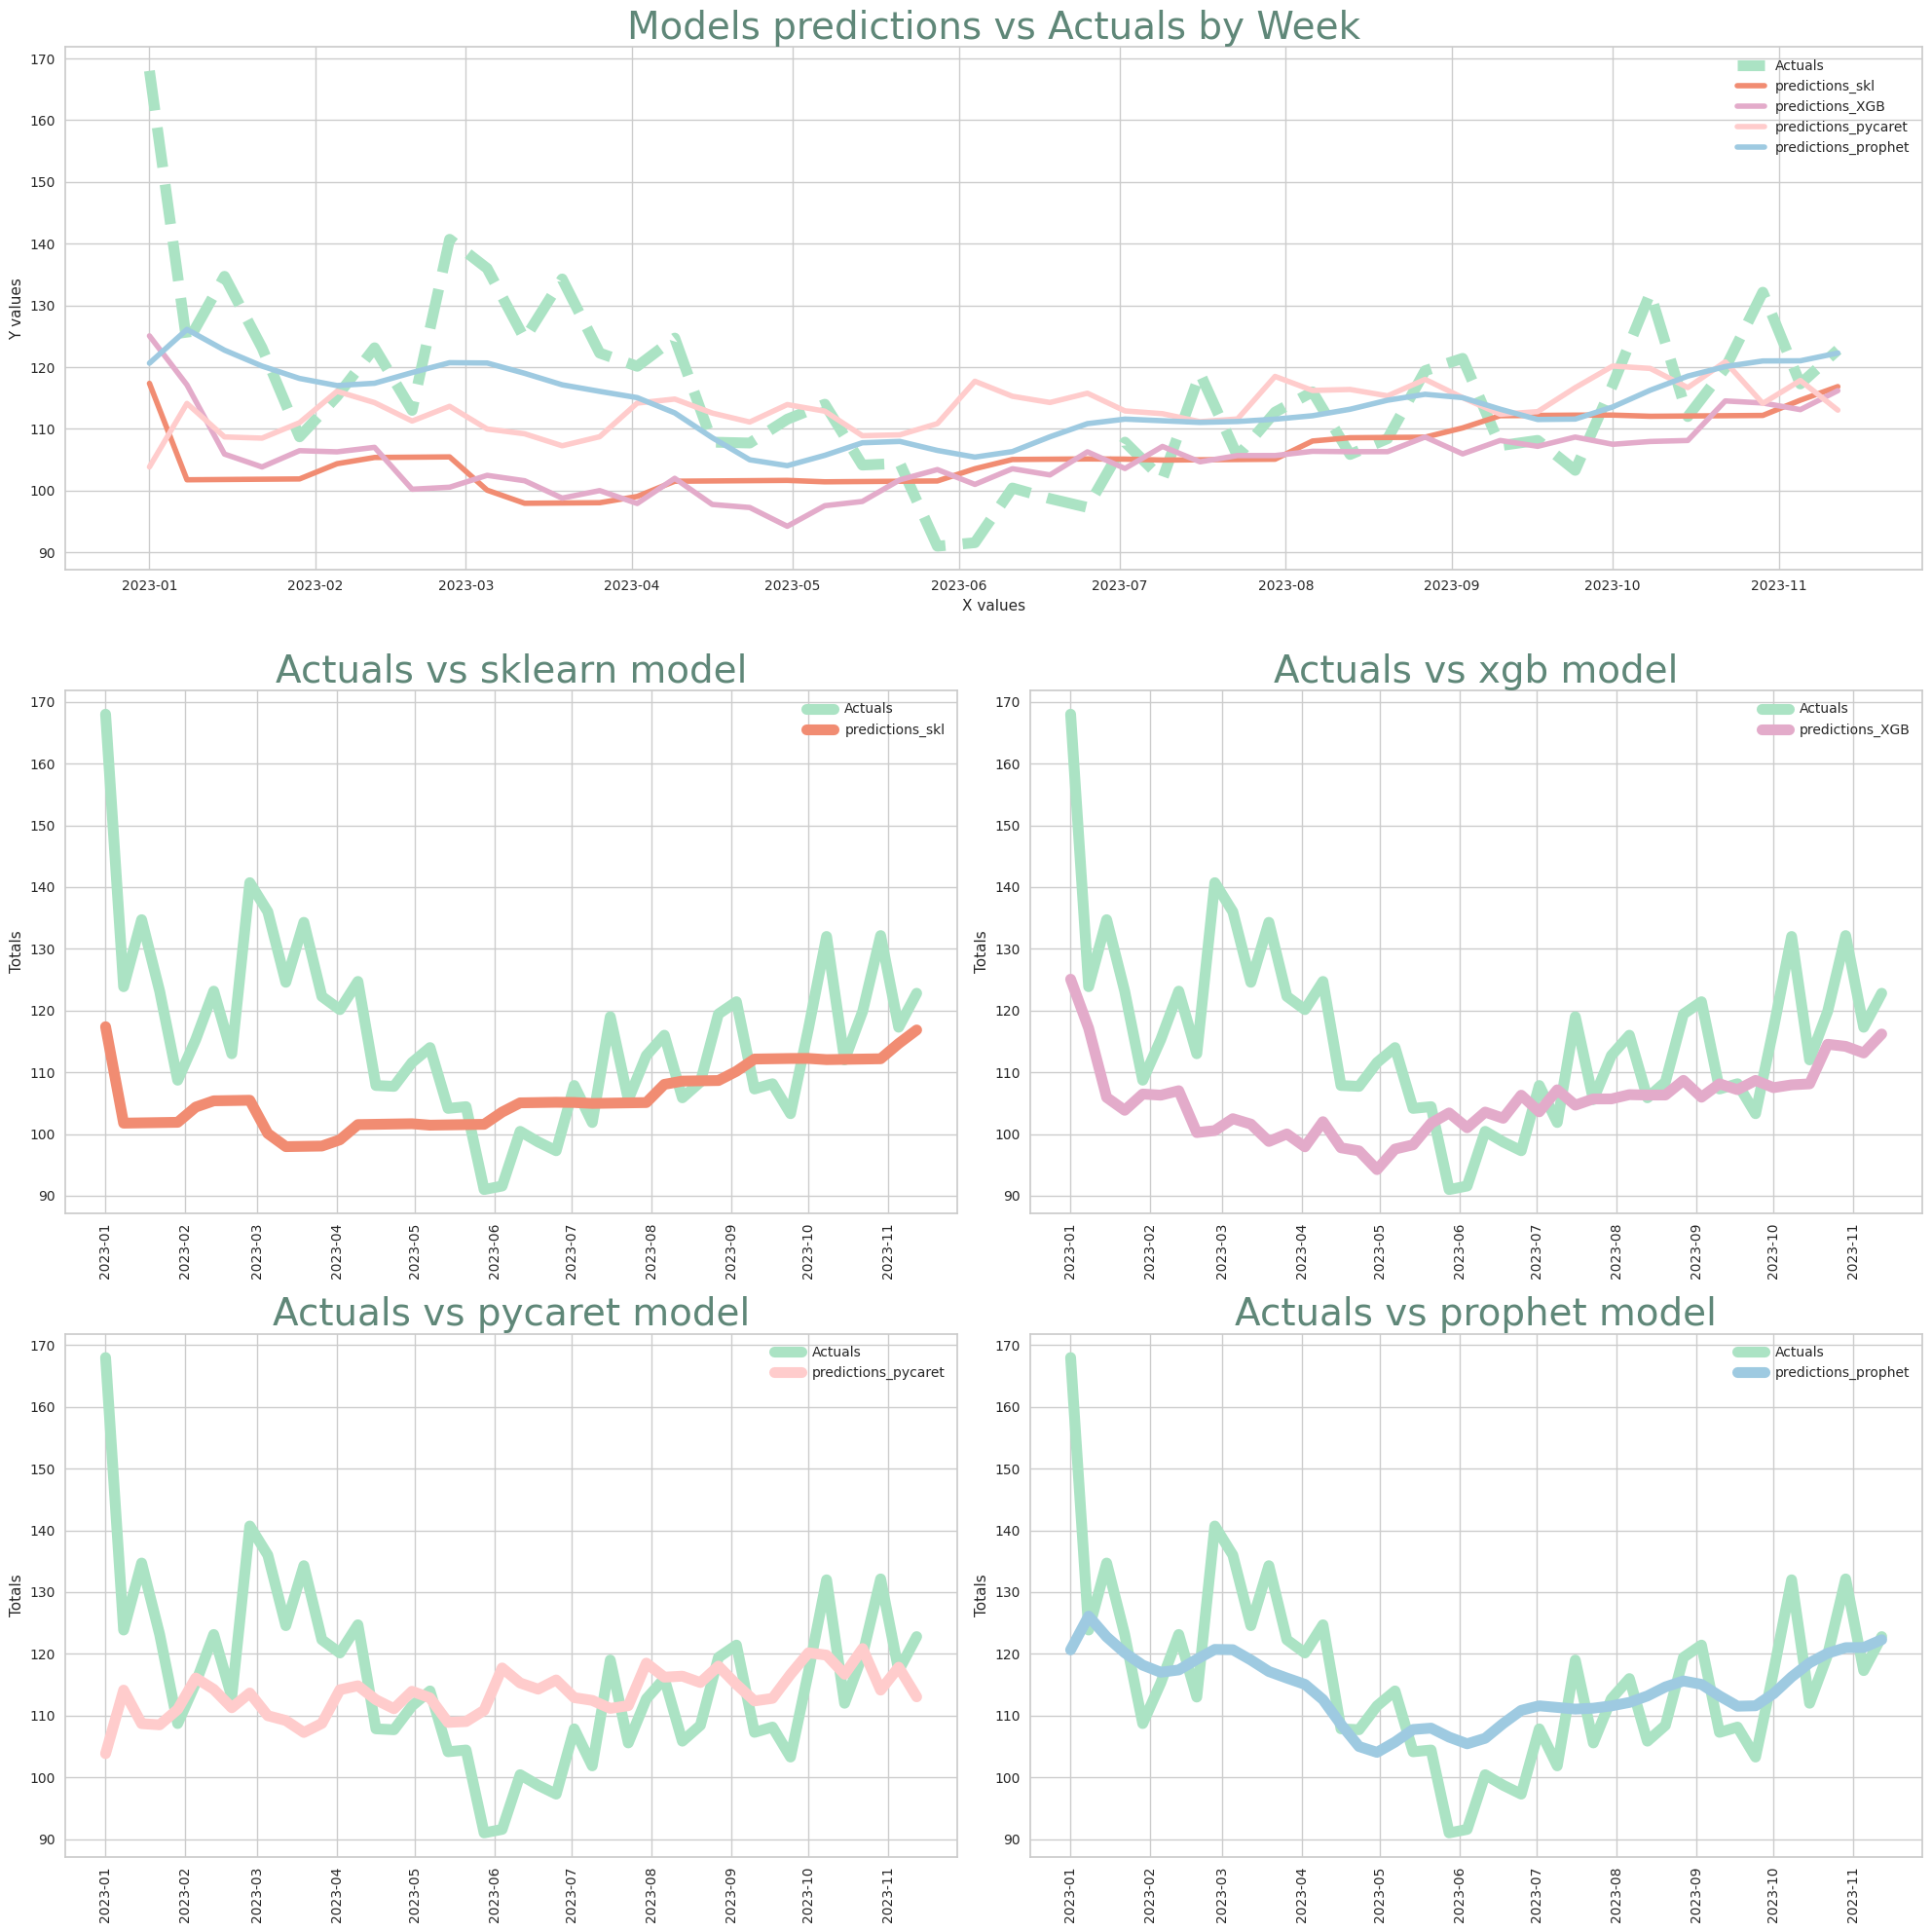

In [47]:
model_results = RESULTS_2023.columns

fig = plt.figure(tight_layout=True, figsize=(20, 20))

# fig  = plt.subplots(tight_layout=True, figsize=(16, 20))
gs = gridspec.GridSpec(3, 2)

RESULTS_2023.index = pd.to_datetime(RESULTS_2023.index)
RESULTS_2023_weekly = RESULTS_2023.resample('W').mean()

ax1 = fig.add_subplot(gs[0, :])
ax1.plot(RESULTS_2023_weekly.index, RESULTS_2023_weekly['actuals_2023'], label = 'Actuals', color=color_brand[0], linewidth=8, linestyle='--')

col_index_ = [6, 4, 5, 8]
for index, item in enumerate(model_results[1:]):
    ax1.plot(RESULTS_2023_weekly.index, RESULTS_2023_weekly[item], label = item, color = color_brand[col_index_[index]], linewidth=4)

ax1.set_xlabel('X values')
ax1.set_ylabel('Y values')
ax1.set_title('Models predictions vs Actuals by Week', fontdict=titles_dict)
ax1.legend()

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(RESULTS_2023_weekly['actuals_2023'], label = 'Actuals', color = color_brand[0], linewidth=8)
ax2.plot(RESULTS_2023_weekly[model_results[1]], label = model_results[1], color=color_brand[6], linewidth=8)
ax2.set_ylabel('Totals')
ax2.set_title('Actuals vs sklearn model', fontdict=titles_dict)
ax2.legend()
plt.xticks(rotation='vertical')

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(RESULTS_2023_weekly['actuals_2023'], label = 'Actuals', color = color_brand[0], linewidth=8)
ax3.plot(RESULTS_2023_weekly[model_results[2]], label = model_results[2], color=color_brand[4], linewidth=8)
ax3.set_ylabel('Totals')
ax3.set_title('Actuals vs xgb model', fontdict=titles_dict)
ax3.legend()
plt.xticks(rotation='vertical')

ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(RESULTS_2023_weekly['actuals_2023'], label = 'Actuals', color = color_brand[0], linewidth=8)
ax4.plot(RESULTS_2023_weekly[model_results[3]], label = model_results[3], color=color_brand[5], linewidth=8)
ax4.set_ylabel('Totals')
ax4.set_title('Actuals vs pycaret model', fontdict=titles_dict)
ax4.legend()
plt.xticks(rotation='vertical')

ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(RESULTS_2023_weekly['actuals_2023'], label = 'Actuals', color = color_brand[0], linewidth=8)
ax5.plot(RESULTS_2023_weekly[model_results[4]], label = model_results[4], color=color_brand[8], linewidth=8)
ax5.set_ylabel('Totals')
ax5.set_title('Actuals vs prophet model', fontdict=titles_dict)
ax5.legend()
plt.xticks(rotation='vertical')

plt.show()

# Project Conclusion 🎉📊

**Project Journey:**
- **Data Evaluation:** Explored and assessed the dataset, addressing outliers for improved model accuracy.
- **Train-Test Split:** Divided the dataset into training and testing sets to ensure robust model evaluation.
- **Model Training:**
  - Trained a basic Linear Regression model as a baseline.
  - Explored advanced models using pycaret, xgboost, and prophet.

**Key Findings:**
- **Sklearn & XGBoost have pretty fair MSE scores, but just don't follow the Trend line.**
- **PyCaret Orthagonal Matching Pursuits & Prophet Models score well(ise) on MSE & R2 & clearly follow the Trend line.**

**Next Steps:**
- Fine-tune and optimize the Prophet model & Seasonal Naive models for even more accurate forecasting.
- Explore additional features and model enhancements for continuous improvement.

**Closing Thoughts:**
This project marks a successful journey in understanding and predicting call volumes. The spotlight on Prophet's accuracy paves the way for future improvements and insights, however PyCaret is a really efficient way of Testing Multiple Models.

>